In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = .0033 #keV

#for detector 1.

p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

In [4]:
#x = np.arange(0,200,0.002)
#Er = 93*np.exp(-x/29) #For NR from Kennedy Thesis 

N = 100000
#Er = np.random.exponential(40,np.uint32(N*0.3)) #tip from anthony 
#Er = np.arange(0,200,0.002)
Er = np.random.uniform(0,200,N)
#need to store all of this inorder to calculate fano factor.
ER = []
Yield = []
PtNr = []
QR = []
sigQ = []
sigP = []
sigQ1 = []
sigP1 = []
Err=[]

U1 = []
U2 = []
N_eh = []

QNR=[]
PT1 = []


In [5]:
#For Nuclear Recoils 
F =100

'''
Neh = Y*Enr/eps
#(ylindv(Enr*1000.0)*Enr)/(eps/1000)
sigf_p = q*V*np.sqrt(Neh*F)
sigf_q = eps*np.sqrt(Neh*F)
'''


    
#Enr = np.random.choice(np.arange(10,100))
Enr = 40
    
Err.append(Enr)

esp = 11.5*Enr*(23)**-(7/3)
g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
Y = k*g/(1+k*g)
    

    
 #number of electron-hole pairs. 
Ptnr = (Y*Enr*V)/(eps*1000) + Enr #central value of Pt
Qnr = Y*Enr
    
    

    #(ylindv(Enr*1000.0)*Enr)/(eps/1000)
    #sigf_p = q*V*np.sqrt(Neh*F)
    #sigf_q = eps*np.sqrt(Neh*F)
    
    
    #Without Fano Factor 



for i in np.arange(0,N):
    
    Neh = Y*Enr/eps
    N_eh.append(Neh)
    
    sig_p1 = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) )  
    sig_q1 = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) )
    
   #With Fano Factor. 
    sig_p = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) + (V/1000)**2*Neh*F)  #Phonon uncertainty (energy dependent)
    sig_q = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) + eps**2*Neh*F) #Charge uncertainty 
    

    
    sigQ.append(sig_q)
    sigP.append(sig_p)
    sigQ1.append(sig_q1)
    sigP1.append(sig_p1)
    
    
    Fnr = np.random.normal(0.0,sig_p)#random sample assuming phonon variance 

    Fq = np.random.normal(0.0,sig_q) #random sampel assuming charge variance 
    

    #Ptnr = (Y*Enr*V)/eps + Enr #total phonon energy 
    Ptnr1 = Ptnr + Fnr #not central value! just.. smeared 
    PT1.append(Ptnr1)

    Qnr1 = Qnr + Fq 

    QNR.append(Qnr1)
    
    U_1 = Ptnr/(Ptnr-Qnr1*(V/(eps*1000)))**2 #derivative with respect to Qnr1
    U1.append(U_1)
    U_2 = -Qnr1/(Ptnr1 -(Qnr1*V/(eps*1000)))**2      #derivative with respect to Ptnf
    U2.append(U_2)
    
    Ernr = Ptnr1 - (V/(eps*1000))*Qnr1
    ER.append(Ernr)

    yield1 = Qnr1 / Ernr
    Yield.append(yield1)

    

In [6]:
max(ER)

56.327519203937825

In [7]:
Yield_er = []
ERer = []



In [8]:
#For Electron Recoils. 

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(N):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_pee = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_qee = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_pee) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_qee) #Random assuming charge variane


    Pter = (1+(V/eps/1000))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps/1000)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [9]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

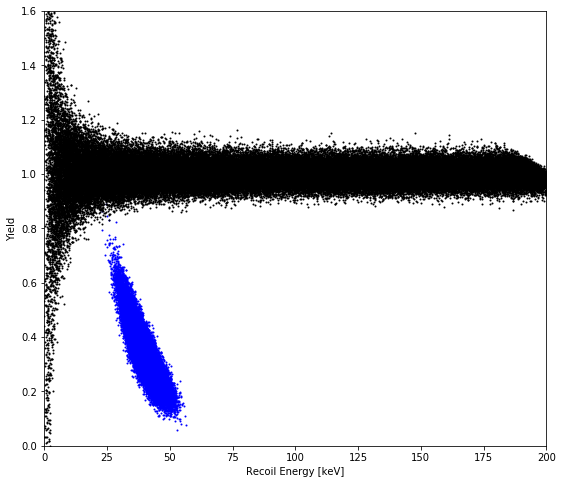

In [10]:
#plot 


fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER,Yield,'o',color='b',linewidth=2,markersize=1)
ax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=1)
'''
ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)
'''
ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('Yield')
ax1.set_ylim(0,1.6)
ax1.set_xlim(0,200)


plt.show()


In [11]:
print(len(ER))
print(len(sigQ1))
print(len(sigP1))
print(len(Yield))
print(len(U1))
print(len(U2))
print(len(N_eh))


100000
100000
100000
100000
100000
100000
100000


In [12]:
data = np.vstack((ER,Yield,sigQ1,sigP1,U1,U2,N_eh)).T


x = data[data[:,1]>=0, :]

data1 = x[x[:,1]<=1.6,:]
data2 = data1[data1[:,0]>=0,:]



data1 = data2[np.argsort(data2[:, 0])]

[36.77520139 36.7753748  36.77538346 ... 38.00691162 38.00717101
 38.00738093]


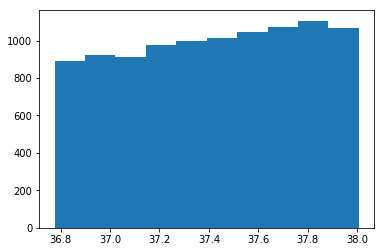

In [13]:
#a,b,c,d,e,f,g = np.array_split(data1,7)
data = np.array_split(data1,10)

plt.hist(data[2][:,0])
print(data[2][:,0])


In [14]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [15]:
#Finds the width in a yield dist for a particular energy bin to be used later in yield variance calculation (fano)
def find_sigma(data):
    mu,sigma = norm.fit(data[:,1])
    
   # gaus(data[:,1],2,0.03,0.05)
    
    n,bins = np.histogram(data[:,1],60)
    
    a = max(data[:,1])
    b = np.average(data[:,1])
    c = sigma
    
    popt,pcov = curve_fit(gaus,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    #plt.figure()
    #plt.hist(data[:,1],bins =60)
    #plt.plot(bins,gaus(bins,*popt), 'r--', linewidth = 2)
    #plt.xlabel("Yield")
    #plt.show()
    
    return  pcov, popt

In [16]:
#finds average fano in particular energy bin
def gaus1(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_fano(data):
    
    mu,sigma = norm.fit(data)
    
    #gaus1(data,2,0.03,0.05)
    
    n,bins = np.histogram(data,60)
    
        
    a = max(data)
    b = mu
    c = sigma
    
    
    popt1,pcov1 = curve_fit(gaus1,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    #plt.figure()
    #plt.hist(data,bins =60)
    #plt.plot(bins,gaus(bins,*popt1), 'r--', linewidth = 2)
   # plt.xlabel("Extracted Fano")
    #plt.show()
    
    return  popt1, pcov1, mu

In [17]:

sig = []
for this_data in data:
    x,y = find_sigma(this_data)
    #print(x,y)
    sig.append(y[2])
    
#print(sig)

In [18]:
#Fano = (b[:,4]**2*b[:,2] +b[:,5]**2*b[:,3] -sigma)**2/(b[:,6]*(b[:,4]**2*eps + V/1000*b[:,5]**2))

def calc_fano(data,sig):
    mean = []
    error = []
    for x, sigy in zip(data, sig):
        #x = data[i]
        U1 = x[:,4]
        U2 = x[:,5]
        sigQ = x[:,2]
        sigP = x[:,3]
        N = x[:,6]
        
        Fano = (-U1**2*sigQ**2-U2**2*sigP**2 + sigy**2)/(U1**2*eps**2 +U2**2*(V/1000)**2)
        Fano = Fano/N
        #print(min(x[:,0]),max(x[:,0]))
        
        x,y,z = find_fano(Fano)
        
        mean.append(x[1])
        error.append(np.sqrt(y[2,2]))
        
        
        #print("mean :",x[1],",","uncertainty in mean : ",y[1,1])
        print(x)

       
    return mean, error
        
        



[565.88428214  29.42465483   8.9196621 ]
[519.23786246  19.83585665   5.6302141 ]
[544.69155055  19.49618321   5.39546844]
[467.19119542  20.78304161   5.66820391]
[519.15357732  20.25173596   5.42594064]
[545.21539055  20.79690584   5.4840182 ]
[574.13152496  20.74275006   5.33458423]
[527.4947842   21.14803395   5.35863585]
[561.40249218  22.80403431   5.67072487]
[604.1595759   30.18766701   7.27817028]


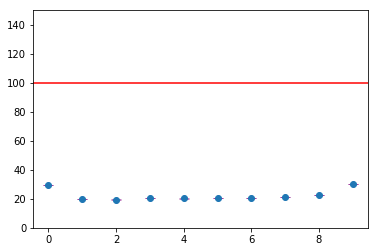

In [19]:
means,errors = calc_fano(data,sig)


x = np.arange(0,10)

plt.figure()
plt.errorbar(x,means,yerr=errors,fmt ='o',label = 'error', ecolor = 'purple', Linestyle = 'None', capsize=5, capthick=0.5)
plt.axhline(y=F, color='r', linestyle='-')
plt.ylim(0,150)
plt.show()